# Notebook 8 - 2D Exciton-Polaritons
---

In this notebook we will investigate a more realistic problem involving polaritons, i.e., the exciton-polaritons which arise when a 2D material hosting strong excitonic resonances is coupled to a planar cavity. While a full ab-initio treatment of excitons would require the solution of the Bethe-Salpeter equation (BSE), a simplified (but yet rather accurate) approach is to solve the excitonic problem as an hydrogenic one, where the effective masses and dielectric screening of the Coulomb interaction are calculated via DFT atomistic calculations. Once the excitonic Hamiltonian is set up, one could then go on and couple the problem to the cavity electromagnetic field to find the new polaritonic states. The latter can be finally used to, for example, investigate the changes in the optical response of the cavity-matter system.

## The Mott-Wannier model for 2D excitons
---

In the MW model, the exciton is treated as a hydrogen atom, where the electron and the hole interact via a screened Coulomb interaction, described by the Schrödinger equation:

$$
\left[-\frac{\nabla^2}{2\mu} - W(\bf{r})\right] F^{n}({\bf{r}}) = E^{n}_{b} F^{n}(\bf{r}).
$$

with $\mu$ the exciton effective mass and the screened Coulomb interaction, here approximated as the Keldysh interaction

$$
W({\bf r})=\frac{1}{4\alpha}\left[H_0(x)-N_0(x)\right]_{x=r/2\pi\alpha} ,
$$

where $H_0$ and $N_0$ are the Struve and Neumann functions and $\alpha$ is the crystal polarizability.
By solving the MW problem, we obtain exciton binding energies ($E^{n}_{b} = E_{\rm{gap}} - E^{n}_{\rm{exc}}$ with $E^{n}_{\rm{exc}}$ the energy of the excitonic resonance) and real space excitonic functions $F^{n}(\mathbf{r})$. Within the MW model, the latter represents the Fourier transforms of the envelope functions $A_{\rm{\bf{k}}}^{n}$, i.e.,

$$
F^{n}({\bf{r}}) = \frac{1}{N_k}\sum_{\bf{k}}A_{\rm{\bf{k}}}^{n}e^{i{\bf{k}\cdot\bf{r}}} .
$$

We stress that the coefficients $A_{\rm{\bf{k}}}^{n}$ used in this Notebook are the MW approximation to those defined above for the BSE.

For the calculations on the $\mathrm{MoS}_2$ polaritons we used an excitonic effective mass of $0.27$ a.u. and a band gap of $2.4$ eV as calculated from the $\mathrm{G}_0\mathrm{W}_0$ band structure. The Keldysh screened electron-hole interaction is calculated with a polarizability $\alpha=13.5$ a.u.. 

## Q 8.1
---
Use the functions below to set up and solve the Mott-Wannier problem. Plot the eigenergies and the first few wavefunctions (use the reshape function below to get the arrays to plot). What symmetries do they have?

In [9]:
# Build Mott-Wannier Problem
import numpy as np

import scipy.sparse as sp
from scipy.special import yn, struve
from scipy.sparse.linalg import eigsh

import matplotlib.pyplot as plt
from matplotlib import cm

# Construct the real space 2D grid
def get_grid_rs(ds, S):
    # ds: grid spacing
    # S: grid size

    X = np.arange(-S/2., S/2., ds)
    Y = np.arange(-S/2., S/2., ds)
    XY_mesh_1, XY_mesh_2 = np.meshgrid(X, Y)
    XY_grid = np.vstack((XY_mesh_1.flatten(), XY_mesh_2.flatten())).T
    return XY_grid, X, Y

# Construct the Keldysh potential
def get_potential_Keldysh(kappa, alpha, XY_grid, ds):
    # kappa: screening parameter from substrate
    # alpha: Keldysh parameter
    # XY_grid: 2D grid
    # ds: grid spacing

    r_grid = np.linalg.norm(XY_grid, axis=1)

    if alpha < 1e-5:  # we just set the potential to 1/(kr)
        W_r = -1. / kappa / r_grid
        # Taking care of the divergence by integration in 2D sphere
        r_c = ds / 2.
        i_rc = np.where(r_grid < r_c)[0]
        W_r[i_rc] = -2. / kappa / r_c
    else:
        r_0 = 2. * np.pi * alpha
        W_r = np.pi / 2. / r_0 * (yn(0, kappa * r_grid / r_0) -
                                    struve(0, kappa * r_grid / r_0))
        # Taking care of the divergence by integrating
        r_c = ds / 2.
        i_rc = np.where(r_grid < r_c)[0]
        W_r[i_rc] = 1. / r_0 * np.log(kappa * r_c / r_0)
    return W_r

# Construct the MW Hamiltonian
def get_H_MW(eff_mass, kappa, alpha, ds, S):
    # eff_mass: effective mass
    # kappa: screening parameter from substrate
    # alpha: Keldysh parameter
    # ds: grid spacing
    # S: grid size

    XY_grid, X, Y = get_grid_rs(ds, S)
    W_r = get_potential_Keldysh(kappa, alpha, XY_grid, ds)

    N_grid = len(XY_grid)
    NX_grid = len(X)
    NY_grid = len(Y)
    dX = dY = ds
    H = np.zeros((N_grid, N_grid), dtype=complex)
    for i in range(0, N_grid):
        i_x = i % NX_grid
        i_y = i // NX_grid
        H[i, i] = (1. / dX**2 + 1. / dY**2) / eff_mass + W_r[i]
        # stencil x-direction
        if i_x + 1 < NY_grid:
            H[i, i + 1] = -1. / 2. / eff_mass / dX**2
        if i_x - 1 >= 0:
            H[i, i - 1] = -1. / 2. / eff_mass / dX**2

        # stencil y-direction
        if i_y + 1 < NY_grid:
            H[i, i + NX_grid] = -1. / 2. / eff_mass / dY**2
        if i_y - 1 >= 0:
            H[i, i - NX_grid] = -1. / 2. / eff_mass / dY**2
    return H

# Function for diagonalization
def diagonalize_H(H, k=30):
    H_sparse = sp.csr_matrix(H)
    # ee, ev = eig(H)
    ee, ev = eigsh(H_sparse, k=k, sigma=-1.984)
    # cherry picked value so that it is lower than lowest eig

    index_sort = np.argsort(ee.real)
    ee = ee[index_sort]
    ev = ev[:, index_sort]
    return ee, ev

# Reshape wfs to plot with pcolormesh
def reshape_wf(i_es, es, ds, S):
    # i_es: index of the eigenstate
    # es: eigenstates
    # ds: grid spacing
    # S: grid size

    wf = np.abs(es[:, i_es])**2
    XY_grid, X, Y = get_grid_rs(ds, S)
    X_grid = XY_grid[:, 0].reshape((len(X), len(Y)))
    Y_grid = XY_grid[:, 1].reshape((len(X), len(Y)))
    wf_reshaped = wf.reshape(X_grid.shape)

    # Example on how to use these quantities to plot with pcolormesh
    #min_val = np.min(wf_reshaped)
    #max_val = np.max(wf_reshaped)
    #cp = axs[1].pcolormesh(X_grid, Y_grid, wf_reshaped, cmap=cm.Reds, vmin=min_val, vmax=max_val)
    #cbar = fig.colorbar(cp, ax=axs[1])
    #cbar.set_label(r'$|\Psi|^2$', rotation=270, labelpad=17)
    #ax.set_xlabel(r'$x$ [a.u.]')
    #ax.set_ylabel(r'$y$ [a.u.]')
    #ax.set_aspect('equal')
    #ax.set_title('Eigenstate n=%s' %i_es)

    return X_grid, Y_grid, wf_reshaped

## A 8.1
---

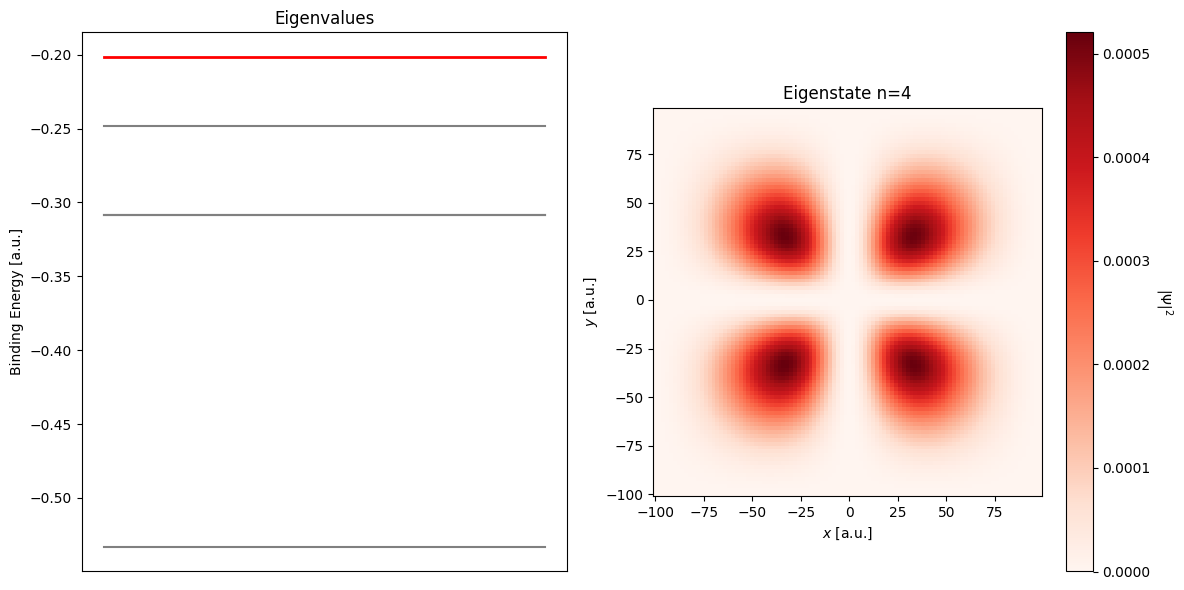

In [10]:
# Build MW Hamiltonian
ds = 2
S = 200
H_MW = get_H_MW(eff_mass=0.27, kappa=1, alpha=13.5, ds=ds, S=S)
Ha2eV = 27.2114
ev, es = diagonalize_H(H_MW, k=5)

# Select the state to visualize
i_es = 4
x_ev = np.zeros((len(ev), 2))
x_ev[:, 1] = 1
y_ev = np.zeros((len(ev), 2))
y_ev[:, 0] = y_ev[:, 1] = ev * Ha2eV

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Eigenvalues
axs[0].set_ylabel('Binding Energy [a.u.]')
axs[0].set_title('Eigenvalues')
for i in range(len(ev)):
    if i == i_es:
        axs[0].plot(x_ev[i], y_ev[i], ls='-', c='red', lw=2)
    else:
        axs[0].plot(x_ev[i], y_ev[i], ls='-', c='gray')
axs[0].set_xticks([])
axs[0].set_xticklabels([])

# Plot Wavefunction
X_grid, Y_grid, wf_grid = reshape_wf(i_es, es, ds, S)
min_val = np.min(wf_grid)
max_val = np.max(wf_grid)

cp = axs[1].pcolormesh(X_grid, Y_grid, wf_grid, cmap=cm.Reds, vmin=min_val, vmax=max_val)
cbar = fig.colorbar(cp, ax=axs[1])
cbar.set_label(r'$|\Psi|^2$', rotation=270, labelpad=17)
axs[1].set_xlabel(r'$x$ [a.u.]')
axs[1].set_ylabel(r'$y$ [a.u.]')
axs[1].set_aspect('equal')
axs[1].set_title('Eigenstate n=%s' %i_es)

plt.tight_layout()
plt.show()

## Coupled Exciton-Light Problem

The light-matter coupling is described by quantum-electrodynamics where the many-body electron and photon state is described by a combined Hamiltonian. Specializing this Hamiltonian to the case of a single cavity mode of frequency $\Omega$ and long-wavelength electron-photon coupling, the Hamiltonian for a perfect loss-less cavity in velocity gauge is

$$
\hat{H}_{\rm{QED}} =  \hat{H}_{\rm{el}} + \Omega \hat{a}^\dagger \hat{a} +  N_{\rm{el}}\frac{A_0^2}{2}(\hat{a}^\dagger + \hat{a})^2+ 
  A_0 \sum_{ij\bf{k}}\left(\langle\phi_{i\bf{k}} | \hat{e}\cdot\hat{p} | \phi_{j\bf{k}}\rangle \hat{d}^\dagger_{i\bf{k}}\hat{d}_{j \bf{k}} \hat{a}^\dagger +  h.c.\right),
$$

where $a^\dagger$ and $a$ are the photon creation and annihilation operators respectively, $\hat{H}_{\rm{el}}$ the many-body electronic Hamiltonian, $\hat{d}^\dagger_{i\bf{k}},\hat{d}_{j \bf{k}}$ the electronic creation and annihilation operators (with $i,j$ band indices and $\bf{k}$ wavevectors in the first Brillouin zone), $\hat{p}$ the single particle momentum operator, $N_{\rm{el}}$ the number of electrons, $\hat{e}$ the polarization of the photon and $A_0$ is the vector potential amplitude.

Since the coupling of photons to the electronic structure occurs via the creation/annihilation of neutral electron-hole pairs, it is natural to approximate the eigenstates of the many-body electronic Hamiltonian by its excitonic eigenstates, i.e. $\hat{H}_{\rm{el}}|\Psi_{n}^{\rm{exc}}\rangle\simeq\epsilon_n^{\rm{exc}}|\Psi_{n}^{\rm{exc}}\rangle$. Within this assumption we can accurately describe a regime where the concentration of excitons is low enough to neglect exciton-exciton interaction, which is the case for non-pumped cavities. Under the approximation that the electron-hole Coulomb interaction that binds the exciton is not affected by the photons in the cavity, i.e. the screened Coulomb interaction is not dressed by the cavity photons, the QED Hamiltonian can be expanded in the excitonic basis as

$$
\langle\Psi_{n}^{\rm{exc}}|\hat{H}_{\rm{QED}}|\Psi_{m}^{\rm{exc}}\rangle =
\left[\epsilon_{n}^{\rm{exc}} + \Omega \hat{a}^\dagger \hat{a}  + N_{el} \frac{A_0^2}{2}(\hat{a}^\dagger + \hat{a})^2\right]\delta_{nm} +
A_0 \left(\mathcal{M}^{\rm exc}_{nm} \hat{a}^\dagger + \mathcal{M}^{\rm exc *}_{mn} \hat{a}\right), 
$$

where $\mathcal{M}^{\rm exc}_{nm} = \sum_{ij\bf{k}} \langle\phi_{i\bf{k}} | \hat{e}\cdot\hat{p} | \phi_{j\bf{k}}\rangle \langle\Psi_{n}^{\rm{exc}}|\hat{d}^\dagger_{i\bf{k}}\hat{d}_{j \bf{k}}|\Psi_{m}^{\rm{exc}}\rangle $
are excitonic matrix elements of the bilinear dipole electron-photon coupling and $\phi_{i\mathbf{k}}$ are single particle Bloch functions. 

In this framework the excitonic states can be expressed as a linear combination of singly excited electronic determinants, where the coefficients of the linear combination are given by the solution of either the BSE or the MW model,

$$
|\Psi_{n}^{\rm{exc}}\rangle = \sum_{cv\bf{k}} A_{cv\bf{k}}^{n} \hat{d}^\dagger_{c\bf{k}}\hat{d}_{v \bf{k}}|\Psi_0\rangle,
$$

with $A_{cv\bf{k}}^{n}$ the BSE or MW coefficients, or envelope functions and $c$ and $v$ indices running over conduction and valence bands respectively. The electronic groundstate $|\Psi_0\rangle$ instead is assumed to be a single determinant of only valence states and we define $|\Psi_{\rm{n}=0}^{\rm{exc}}\rangle=|\Psi_0\rangle$.

Here we consider the non-dispersive (momentum independent) excitonic states localized around the K-points of the Brillouin zone of the TMD, which are the most relevant for the optoelectronic properties of TMDs. These excitonic states occur in two spin-orthogonal non-hydrogenic series, each of which is accurately described by a spin-independent two-band BSE, where only a single valence and a single conduction band are taken into account. With this simplification the momentum matrix elements have one of the two following structures:

$$
\mathcal{M}^{\rm exc}_{0n} =\sum_{\rm{\bf{k}}} A_{\rm{\bf{k}}}^{n}\langle \phi_{v\bf{k}} | \hat{e}\cdot\hat{p} | \phi_{c\bf{k}}\rangle
$$

$$
\mathcal{M}^{\rm exc}_{nm} = N_{el}\sum_{\rm{\bf{k}}} A_{\rm{\bf{k}}}^{m*}A_{\rm{\bf{k}}}^{n}\left[\langle\phi_{c\bf{k}} | \hat{e}\cdot\hat{p} | \phi_{c\bf{k}}\rangle - \langle \phi_{v\bf{k}} | \hat{e}\cdot\hat{p} | \phi_{v\bf{k}}\rangle\right]
$$

The first class of matrix elements are those that dictate the dark/bright nature of the excitonic states. The second, instead, are mixing the character of the excitonic states so that bright to dark or dark to bright transitions can occur. 

Below we show how the QED Hamiltonian can be diagonalized in a mixed exciton-photon product state basis $|\Psi^{\rm exc}_{n}\rangle\otimes|\gamma\rangle$, where $|\gamma\rangle$ are the eigenfunctions of the photonic harmonic oscillator. We then extract energies ($E^{\rm pol}_{I}(\Omega)$) and corresponding eigenfunctions ($|\Psi^{\rm pol}_I(\Omega)\rangle = \sum_{n \gamma} C^{I}_{n\gamma}|\Psi^{\rm exc}_{n}\rangle\otimes|\gamma\rangle$) for the exciton-polariton eigenstates.

## Calculation of the Momentum Matrix Elements in the MW model
---

Borrowing the assumptions of the MW model, in particular that the excitons are extremely localized at certain points in the Brillouin zone, the $K$-points for TMDs, we assume that the valence-conduction momentum matrix element is constant, and simplify the first class of momentum matrix element to:

$$
\mathcal{M}^{\rm exc}_{0n} = \langle\phi_{\rm{vK}} | \hat{e}\cdot\hat{p} | \phi_{\rm{cK}}\rangle F^{n}({\bf{r}}=0).
$$

This shows that whether an exciton is bright or dark, is determined by the value of its real space wavefunction at the origin. This explains why only $s$-like excitons are bright. 
Simplifications can also be done for the other class of matrix elements by noting that, for parabolic conduction and valence bands, $\langle\phi_{\rm{v\bf{k}}} | \hat{e}\cdot\hat{p} | \phi_{\rm{v\bf{k}}}\rangle=\hat{e}\cdot\frac{d}{d\bf{k}}\epsilon_{\rm{v\bf{k}}}=-\frac{k}{m_{\rm{h}}}$ and $\langle\phi_{\rm{c\bf{k}}} | \hat{e}\cdot\hat{p} | \phi_{\rm{v\bf{k}}}\rangle=\hat{e}\cdot\frac{d}{d\bf{k}}\epsilon_{\rm{c\bf{k}}}=\frac{k}{m_{\rm{e}}}$ so that we arrive to

$$
\mathcal{M}^{\rm exc}_{mn} 
%= \sum_{\rm{\bf{k}}} A_{\rm{\bf{k}}}^{\rm{m}*}A_{\rm{\bf{k}}}^{\rm{n}}\hat{e}\cdot\left[\frac{k}{m_{\rm{e}}} + \frac{k}{m_{\rm{h}}}\right] 
= \left[\frac{1}{m_h} +  \frac{1}{m_e}\right]\sum_{\rm{\bf{k}}} A_{\rm{\bf{k}}}^{m*} A_{\rm{\bf{k}}}^{n}~\hat{e}\cdot{\bf{k}}  .
$$

The sum in the RHS can be expressed as the expectation value of the dipole operator, $\sum_{\rm{\bf{k}}} A_{\rm{\bf{k}}}^{m*} A_{\rm{\bf{k}}}^{n}~\hat{e}\cdot{\bf{k}}\propto (E_{\rm b, exc}^{m} - E_{\rm b, exc}^{n})\int d{\bf r} F^{m *}(r)\hat{e}\cdot{\bf r} F^{n}(r)$, which yields the typical hydrogen like selection rules $\Delta l = \pm 1$, with $l$ the angular momentum quantum number.

In [11]:
def get_Pmat_MW(n_exc, es, eff_mass, me_cv, X, Y):
    # n_exc: number of excited states (inexcluding groundstate)
    # es: eigenstates
    # eff_mass: effective mass
    # me_cv: conduction band effective mass
    # X: x grid
    # Y: y grid

    me_v = np.array([me_cv, me_cv])
    # in principle, me_cv can be different for x and y

    # Get eig and wfs on real space grid
    X_size = len(X)
    Y_size = len(Y)

    wf_n_grid = es[:, :n_exc]
    wf_n_XY = np.reshape(wf_n_grid.T, (n_exc, X_size, Y_size))

    # Fourier Transformed wfs
    k1 = np.linspace(-np.pi / S, np.pi / S, X_size, endpoint=False)
    k2 = np.linspace(-np.pi / S, np.pi / S, Y_size, endpoint=False)
    k_mesh_1, k_mesh_2 = np.meshgrid(k1, k2)
    k_grid = np.vstack((k_mesh_1.flatten(), k_mesh_2.flatten())).T
    kx_m = np.reshape(k_grid[:, 0], (X_size, Y_size))
    ky_m = np.reshape(k_grid[:, 1], (X_size, Y_size))

    wf_n_kxky = []
    for nn in range(n_exc):
        ft_wf = np.fft.fftn(np.fft.fftshift(wf_n_XY[nn]))
        ft_wf = np.fft.fftshift(ft_wf)
        norm = np.sqrt(np.sum(ft_wf * ft_wf.conj()))
        wf_n_kxky.append(ft_wf/norm)

    wf_n_kxky = np.array(wf_n_kxky)

    # Calculating Momentum Matrix Elements
    # ------------------------------------
    p_mnv = np.zeros((n_exc + 1, n_exc + 1, 2), dtype=complex)
    dk1 = k_grid[1]-k_grid[0]
    dk2 = k_grid[X_size]-k_grid[0]
    dAk = np.linalg.norm(np.cross(dk1, dk2))

    #  \Psi_GS -> \Psi_m
    for m in range(1, n_exc + 1):
        penv_mn = np.abs(np.sum(wf_n_kxky[m - 1]))
        p_mnv[0, m] = penv_mn * me_v

    p_mnv[:, 0] = p_mnv[0, :].conj()

    # \Psi_m -> \Psi_n
    for m in range(1, n_exc+1):
        for n in range(m+1, n_exc+1):
            # x direction
            p_mnv[m, n, 0] = (1./eff_mass *
                              np.sum(wf_n_kxky[m-1].conj() *
                                     wf_n_kxky[n-1] * kx_m) *
                              dAk * me_v[0])
            # y direction
            p_mnv[m, n, 1] = (1./eff_mass *
                              np.sum(wf_n_kxky[m-1].conj() *
                                     wf_n_kxky[n-1] * ky_m) *
                              dAk * me_v[1])

    p_mnv[:, :, 0] += np.conj(p_mnv[:, :, 0].T)
    p_mnv[:, :, 1] += np.conj(p_mnv[:, :, 1].T)

    # Note that the last index of p_mnv is for the x and y polarization components
    return p_mnv

## Q. 8.2
---

Using all the ingredients discussed above and the routine to build the polaritonic Hamiltonian introduced in <font color='blue'>Notebook 7</font>, build and diagonalize the QED-MW problem. After that plot the polaritonic eigenvalues. Use a value of m_cv=0.01.

Suggested steps on how to proceed:
1.  Set-up the Mott-Wannier Hamiltonian using the function `get_H_MW`
2.  From the solutions of the MW eigenproblem build `H_mat`. Note that you will need to include the groundstate
3.  Build P_mat using the function `get_Pmat_MW`. Note that you will have to select a polarization (for example x)
4.  Build the polaritonic Hamiltonian usign `build_Hpol`, a good $A_0$ to start with is 0.02 a.u.
5.  Diagonalize the polaritonic Hamiltonian using `diagonalize_H`. For plotting the eigenvalues it could be useful to also plot the free photon lines.

In the following the functions that you might want to use to build and diagonalize the polaritonic Hamiltonian (same as in <font color='blue'>Notebook 7</font>):

In [12]:
# Build polariton Hamiltonian
def build_Hpol(H_mat, wc, nph, p_mat, A_0):
    # H_mat: Matter Hamiltonian
    # wc: cavity frequency
    # nph: number of photons
    # p_mat: momentum matrix
    # A_0: mode strength

    # ---------------------
    # Light-Matter Diagonal
    # ---------------------
    e_tol = 1e-9
    # Matter
    H_pol_mat_d = np.kron(np.eye(nph), H_mat)

    # Photons
    H_ph_d = (np.diag(np.arange(0., nph*wc-e_tol, wc) + 0.5*wc) +
            1./2. * np.diag(2.*np.arange(0., nph*A_0**2-e_tol, A_0**2) + A_0**2))
    H_pol_ph_d = np.kron(H_ph_d, np.eye(H_mat.shape[0]))

    # ----------------------
    # A^2 term off-diagonal
    # ----------------------
    # sqrt(n+1) factors from the application of the bosonic operator
    n_quad = (np.sqrt(np.arange(0, nph-2, 1) + 1) * np.sqrt(np.arange(0, nph-2, 1) + 2))
    M_quad = np.diag(n_quad, k=2)

    H_A2 = 0.5 * np.kron(M_quad, np.eye(H_mat.shape[0]))
    H_A2 += np.transpose(H_A2).conj()

    # ----------
    # P.A term
    # ----------
    # sqrt(n+1) factors from the application of the bosonic operator
    n_sqrt = np.sqrt(np.arange(0, nph-1, 1) + 1)
    M_sqrt = np.diag(n_sqrt, k=1)

    H_PA = np.kron(M_sqrt, p_mat)
    H_PA += H_PA.T.conj()

    # -----------------
    # Full Hamiltonian
    # -----------------
    H_pol = H_pol_mat_d + H_pol_ph_d + A_0 * H_PA + A_0**2 * H_A2
    return H_pol

## A. 8.2
---

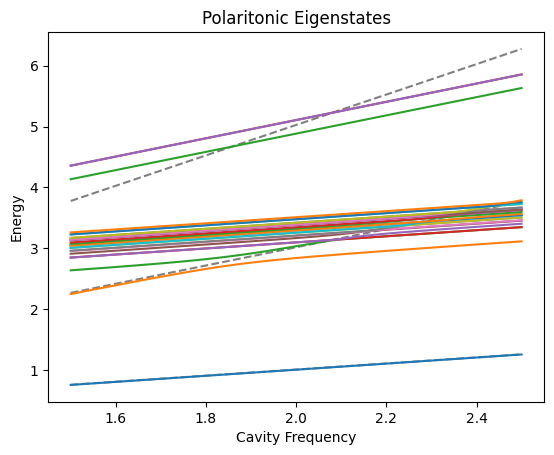

In [13]:
# Set up the Mott-Wannier Hamiltonian
eff_mass = 0.27
me_cv = 0.01
ds = 2
S = 200
XY_grid, X, Y = get_grid_rs(ds, S)
H_MW = get_H_MW(eff_mass=eff_mass, kappa=1, alpha=13.5, ds=ds, S=S)

# Solve the eigenproblem
n_exc = 20
gap = 2.4 / Ha2eV
ev, es = diagonalize_H(H_MW, k=n_exc)

# Build the H_mat: H_mat in the many-body excitonic basis should also include
# the GS and account for the gap
eig_n = ev[:n_exc] + gap
e_m = np.append(0, eig_n)
H_mat = np.diag(e_m)

# Build Pmat for the exciton-Polariton problem
p_mnv = get_Pmat_MW(n_exc, es, eff_mass, me_cv, X, Y)
P_mat = p_mnv[:,:,0]   # x-polarization component

# Create the polaritonic Hamiltonian for an array of cavity frequencies
nph = 2
A_0 = 0.02
wc = np.linspace(1.5, 2.5, 50) / Ha2eV

# Plot the first 25 eigenvalues as a function of frequency
n_sel = 25
ev_sel = []
es_sel = []
for w in wc:
    H = build_Hpol(H_mat=H_mat, wc=w, nph=nph, p_mat=P_mat, A_0=A_0)
    ev, es = diagonalize_H(H, k=n_sel)
    ev_sel.append(ev)
    es_sel.append(es)

ev_sel = np.array(ev_sel)
es_sel = np.array(es_sel)

# Photon lines as guide for the eye
n_l = 2
ph_l = []
for l in range(n_l+1):
    y_l = (l + 0.5)*(wc + A_0**2)
    plt.plot(wc * Ha2eV, y_l * Ha2eV, ls='--', c='gray')

for i in range(n_sel):
    plt.plot(wc * Ha2eV, ev_sel[:, i] * Ha2eV)

plt.xlabel('Cavity Frequency')
plt.ylabel('Energy')
plt.title('Polaritonic Eigenstates')
plt.show()

You can see that only the excitons with the right symmetry (the spherical symmetric ones) undergo formation of polaritons.

## Q. 8.3
---

Finally, with the polaritonic states at hand we can compute the optical conductivity of the cavity-exciton system.

We can calculate the matter component of the optical conductivity $\chi(\omega,\Omega)$ applying linear-response theory on the polaritonic states

$$
\sigma(\omega,\Omega) = \sum_{I}\frac{\mathcal{M}^{\rm pol}_{0I}\mathcal{M}^{\rm pol}_{I0}}{\omega-E^{\rm pol}_{I}(\Omega)+E^{\rm pol}_{0}(\Omega)+i\eta},
$$

where $\mathcal{M}^{\rm pol}_{IJ}=\langle\Psi^{\rm pol}_I|\hat{p}|\Psi^{\rm pol}_{J}\rangle/(E_I-E_J)=\sum_{nm} C^{I*}_{n}C^{J}_{m}\mathcal{M}^{\rm exc}_{nm}/(E_I-E_J)$ and $i\eta$ is a small artificial imaginary broadening.
Such a quantity represents the independent particle polarizability of the polariton to a weak external field coupling with the matter component. 

Use the function below to calculate the optical response function for the cavity-exciton system and the plot function for the colormap plot of the response function.

In [14]:
def calculate_optical_conductivity(ev_wcI, es_wcIJ, wc, w_probe, eta, H_probe):
    # ev_wcI: eigenvalues
    # es_wcIJ: eigenvectors
    # wc: cavity frequency
    # w_probe: probe frequency
    # eta: broadening
    # H_probe: probe Hamiltonian in the exciton+photon basis

    # Calculating momentum matrix elements
    n_trans = ev_wcI.shape[1]

    # Calculating optical conductivity
    cond_wcw = np.zeros((len(wc), len(w_probe)), dtype=float)
    dw = w_probe[1] - w_probe[0]
    for iwc in range(len(wc)):
        M_I = np.dot(es_wcIJ[iwc,:,0].conj(), np.dot(H_probe, es_wcIJ[iwc]))
        #M_I /= np.sum(M_I)

        # The initial state for the transitions is the GS
        f_I = np.ones(n_trans)
        f_I[0] = 0.   # to avoid the transition from GS to GS

        E_I0 = ev_wcI[iwc] - ev_wcI[iwc,0]
        den_wI = np.add.outer(w_probe + 1.j*eta, -E_I0)
        # 1/omega factor for conductivity
        E_I0[np.where(np.abs(E_I0) < 1e-5)] = dw

        cond_wI = (f_I*np.abs(M_I)**2) / den_wI  / E_I0

        # summing over states
        cond_w = -np.imag(np.sum(cond_wI, axis=(1)))
        cond_wcw[iwc] = cond_w

    return cond_wcw

def plot_response_function_2D(wc, w_probe, cond_wcw,
                              xlabel=r'$\omega_{\mathrm{c}}$',
                              ylabel=r'$\omega$', title=None, cmap='Reds',
                              cbarlabel=r'$\sigma$', units='eV', log=True):

    fig, ax = plt.subplots()
    xgrid, ygrid = np.meshgrid(wc, w_probe)

    if not log:
        zgrid = abs(cond_wcw.T)
    else:
        zgrid = np.log(abs(cond_wcw.T))

    cp = ax.pcolormesh(xgrid, ygrid,
                       zgrid,
                       cmap=cmap)

    cbar = fig.colorbar(cp)
    units = ' [' + units + ']'
    ax.set_xlabel(xlabel + units)
    ax.set_ylabel(ylabel + units)
    cbar.set_label(cbarlabel)

    ax.set_title(title)

    return fig

## A. 8.3
---

We set-up the response calculation as follows

In [15]:
w_probe = np.linspace(1.5, 3., 200)/Ha2eV
H_probe = np.kron(np.eye(nph), P_mat)   # we are using the same momentum matrix as for the cavity, for the probe though we are diagonal in the cavity photons

cond_wcw = calculate_optical_conductivity(ev_wcI=ev_sel, es_wcIJ=es_sel, wc=wc, w_probe=w_probe, eta=0.01/Ha2eV, H_probe=H_probe)

Finally we plot the response using the pre-made function below.

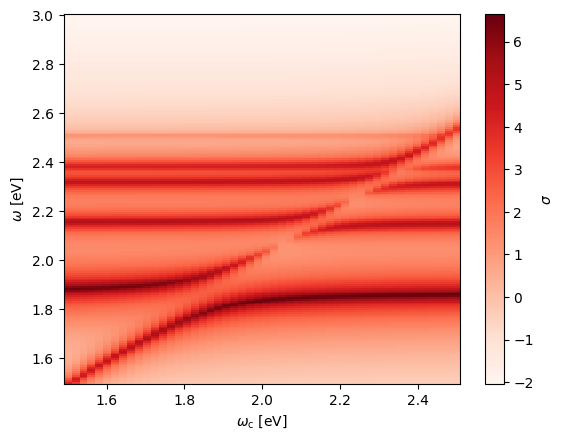

In [16]:
# Plotting optical conductivity

fig = plot_response_function_2D(wc=wc*Ha2eV, w_probe=w_probe*Ha2eV, cond_wcw=cond_wcw)